# 下载CIFAR数据集

In [1]:
import urllib.request
import os
import tarfile

# 下载
#url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
#filepath = 'cifar-10-python.tar.gz'
#if not os.path.isfile(filepath):
#    result = urllib.request.urlretrieve(url,filepath)
#    print('downloaded:',result)
#else:
#    print('Data file already exists.')
    
if not os.path.exists("cifar-10-batches-py"):
    tfile = tarfile.open("cifar-10-python.tar.ge",'r:gz')
    result = tfile.extractall("/")
    print("Extracted to ./cifar-10-batches-py/")
else:
    print("Directory already exists.")

Directory already exists.


# 导入CIFAR数据集

In [2]:
import os
import numpy as np
import pickle as p

def load_CIFAR_batch(filename):
    '''load single batch of cifar'''
    with open(filename,'rb') as f:
        # 一个样本由标签和图像数据组成
        # <1×label><3072 × pixel>(3072=32*32*3)
        # ...
        # <1 × label><3072 × pixel>
        data_dict = p.load(f,encoding='bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        
        # 把原始数据结构调整为;BCWH
        images = images.reshape(10000,3,32,32)
        # tensorflow处理图像数据的结构:BWHC
        # 把通道数据C移动到最后一个维度
        images = images.transpose(0,2,3,1)
        
        labels = np.array(labels)
        
        return images,labels
def load_CIFAR_data(data_dir):
    '''load CIFAR data'''
    
    images_train = []
    labels_train = []
    for i in range(5):
        f = os.path.join(data_dir,'data_batch_%d'%(i+1))
        print('loading',f)
        # 调用load_CIFAR_batch()获得批量的图像及其对应的标签
        image_batch,label_batch = load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch,label_batch
    
    Xtest,Ytest = load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print("finished loadding CIFAR-10 data")
    
    # 返回训练集的图像和标签，测试集的图像和标签
    return Xtrain,Ytrain,Xtest,Ytest

data_dir = 'cifar-10-batches-py/'
Xtrain,Ytrain,Xtest,Ytest = load_CIFAR_data(data_dir)

loading cifar-10-batches-py/data_batch_1
loading cifar-10-batches-py/data_batch_2
loading cifar-10-batches-py/data_batch_3
loading cifar-10-batches-py/data_batch_4
loading cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


# 显示数据集信息

In [3]:
print("training data shape:",Xtrain.shape)
print("training label shape:",Ytrain.shape)
print("test data shape:",Xtest.shape)
print("test label shape:",Ytest.shape)

training data shape: (50000, 32, 32, 3)
training label shape: (50000,)
test data shape: (10000, 32, 32, 3)
test label shape: (10000,)


# 查看单项image和label

2


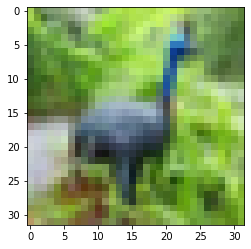

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# 查看image
plt.imshow(Xtrain[6])
# 查看label
print(Ytrain[6])

# 查看多项images与label

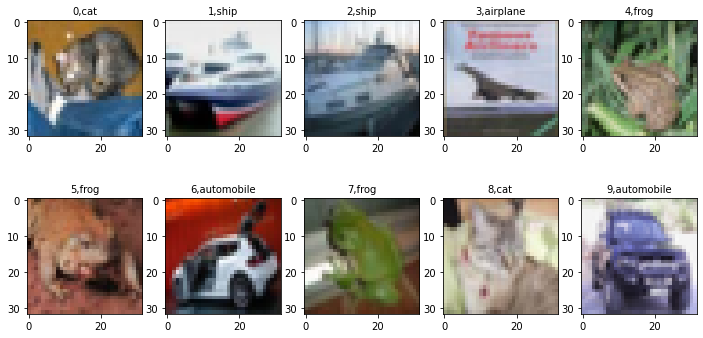

In [5]:
import matplotlib.pyplot as plt

# 定义标签字典,每一个数字所代表的图像类别的名称
label_dict = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",
             6:"frog",7:"horse",8:"ship",9:"truck"}
# 定义显示图像数据及其对应标签的函数
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12,6)
    if num>10:
        num = 10
    for i in range(0,num):
        ax  = plt.subplot(2,5,1+i)
        ax.imshow(images[idx],cmap='binary')
        
        title = str(i)+','+label_dict[labels[idx]]
        if  len(prediction)>0:
            title +='=>'+label_dict[prediction[idx]]
        
        ax.set_title(title,fontsize=10)
        
        idx+=1
    plt.show()
    
# 显示图像数据及其对应标签
plot_images_labels_prediction(Xtest,Ytest,[],0,10)

# 图像数据预处理

In [6]:
# 查看图像数据信息
# 显示第一个图的第一个像素点
Xtrain[0][0][0]

array([59, 62, 63], dtype=uint8)

In [7]:
# 将图像进行数字标准化
Xtrain_normalize = Xtrain.astype('float32')/255.0
Xtest_normalize = Xtest.astype('float32')/255.0

In [8]:
# 查看预处理后图像数据信息
Xtrain_normalize[0][0][0]

array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

In [9]:
import tensorflow as tf
# 建立Sequential线性堆叠模型
model = tf.keras.models.Sequential()

# 第一个卷积层
model.add(tf.keras.layers.Conv2D(filters = 32, 
                                 kernel_size = (3,3),
                                 input_shape=(32,32,3),
                                activation = 'relu',
                                padding = 'same'))

# 防止过拟合
model.add(tf.keras.layers.Dropout(rate=0.3))

# 第一个池化层
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# 第二个卷积层
model.add(tf.keras.layers.Conv2D(filters = 64, 
                                 kernel_size = (3,3),
                                activation = 'relu',
                                padding = 'same'))

# 防止过拟合
model.add(tf.keras.layers.Dropout(rate=0.3))

# 第二个池化层
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters = 64,
                                kernel_size = (3,3),
                                activation = 'relu',
                                padding = 'same'))

# 平坦层
model.add(tf.keras.layers.Flatten())

# 添加全连接层
model.add(tf.keras.layers.Dense(units=128,kernel_initializer='normal',activation='relu'))

# 添加输出层
model.add(tf.keras.layers.Dense(10,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          3

# 模型训练

In [30]:
# 设置训练参数
train_epochs = 30  # 训练轮数
batch_size = 10 # 单次训练样本数

In [12]:
# 定义训练模式
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy']) # 评估模型的方式

# 设置回调函数

In [13]:
# 设置回调参数

# 可以是格式化的字符串，里面的占位符将会被epoch值和传入的监控指标所填入
checkpoint_filepath = './checkpoint/Cifar10.{epoch:02d}-{val_loss:.4f}.h5'

callbacks = [
    # 保存模型的回调函数
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                       save_weights_only=True,  #不保存模型结构
                                       verbose=0,
                                       save_freq='epoch'),
    # 中止训练的回调函数
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3), # patience观察几个周期
]

In [26]:
import os
# 加载模型

checkpoint_dir = './checkpoint/Cifar10.{epoch:02d}-{val_loss:.4f}.h5'   # 检查点文件保存目录
#heckpoint_dir = os.path.dirname(checkpoint_dir)
#rint(checkpoint_dir)
# 得到最新的检查点文件
#odel_filename = tf.train.latest_checkpoint(checkpoint_dir)
#f model_filename != None:
model.load_weights('Cifar10.17-1.0429.h5')
#lse:
 #  print("加载权重失败！")

加载权重成功！


In [31]:
# 训练模型
train_history = model.fit(Xtrain,
                          Ytrain,
                          validation_split = 0.2, 
                          epochs = train_epochs,
                          batch_size = batch_size,
                          callbacks=callbacks,
                          verbose = 2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 - 67s - loss: 0.5365 - accuracy: 0.8138 - val_loss: 1.0452 - val_accuracy: 0.6599
Epoch 2/30
40000/40000 - 68s - loss: 0.4863 - accuracy: 0.8311 - val_loss: 1.0403 - val_accuracy: 0.6719
Epoch 3/30
40000/40000 - 69s - loss: 0.4607 - accuracy: 0.8426 - val_loss: 1.0823 - val_accuracy: 0.6618
Epoch 4/30
40000/40000 - 69s - loss: 0.4384 - accuracy: 0.8504 - val_loss: 1.1132 - val_accuracy: 0.6668
Epoch 5/30
40000/40000 - 67s - loss: 0.4018 - accuracy: 0.8630 - val_loss: 1.1545 - val_accuracy: 0.6659


# 可视化训练过程数据

In [27]:
# 定义训练过程可视化函数
def visu_train_history(train_history,train_metric,validation_metric):
    plt.plot(train_history.history[train_metric])
    plt.plot(train_history.history[validation_metric])
    plt.title('Train History')
    plt.ylabel(train_metric)
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc = 'upper left')
    plt.show()

In [28]:
visu_train_history(train_history,'loss','val_loss')

NameError: name 'train_history' is not defined

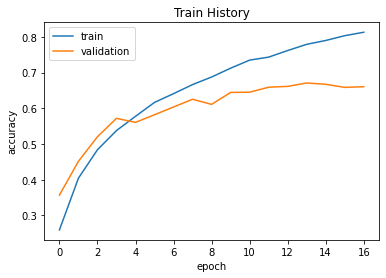

In [33]:
visu_train_history(train_history,'accuracy','val_accuracy')

# 评估模型

In [32]:
# 评估模型
test_loss, test_acc = model.evaluate(Xtest,Ytest,verbose=2)
print("Test accuracy:",test_acc)

10000/10000 - 4s - loss: 1.1436 - accuracy: 0.6628
Test accuracy: 0.6628


# 应用模型

In [35]:
# 进行模型预测
preds = model.predict_classes(Xtest)

In [36]:
preds

array([3, 8, 8, ..., 2, 4, 7], dtype=int64)

# 可视化预测结果

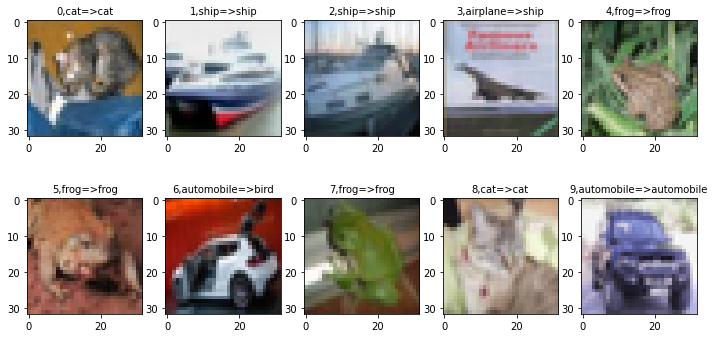

In [37]:
plot_images_labels_prediction(Xtest,Ytest,preds,0,10)